<a href="https://colab.research.google.com/github/egor2025slo/advanced_house_price_prediction/blob/main/Untitled19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# --- LIBRARIES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, norm

# Sklearn Models & Tools
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# Boosting
import xgboost as xgb
import lightgbm as lgb

# Interpretation
import shap

# Configuration
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)

# --- LOAD DATA ---
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Save IDs for submission
test_ID = test['Id']

# Drop ID (noise)
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (1460, 80)
Test shape: (1459, 79)


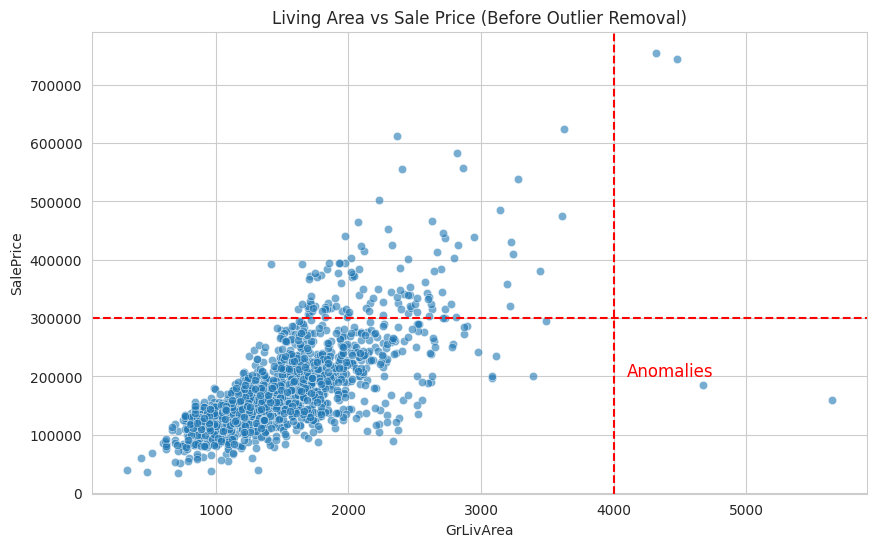

Removed 2 outliers.

--- Analysis before logarithmization ---


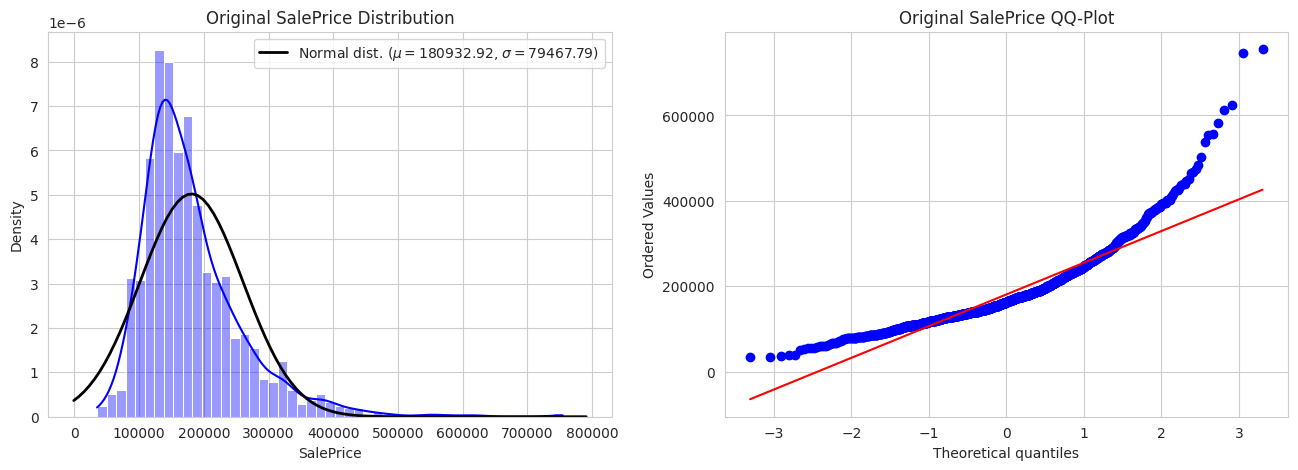


--- Analysis after logarithmization ---


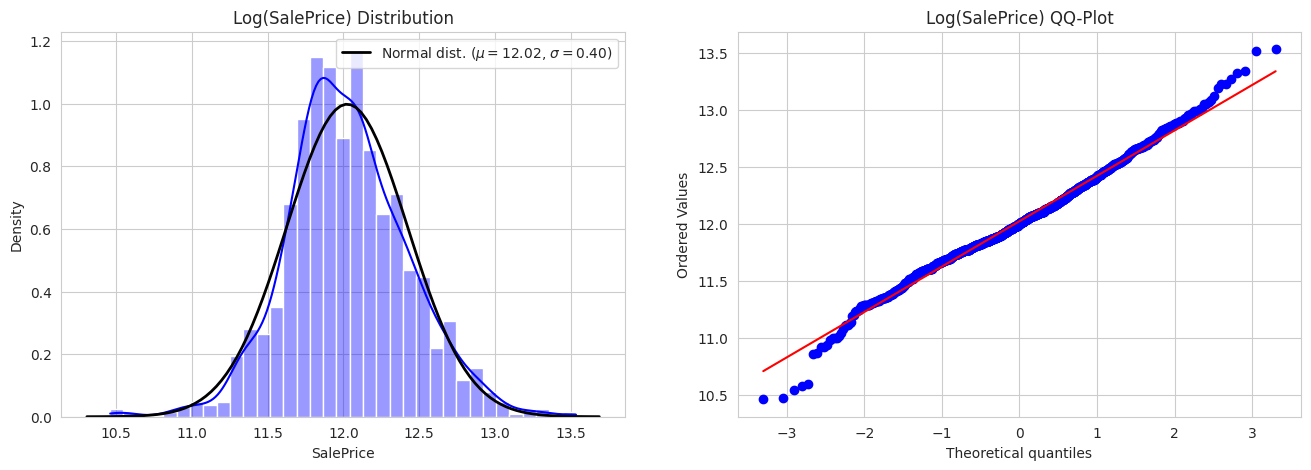

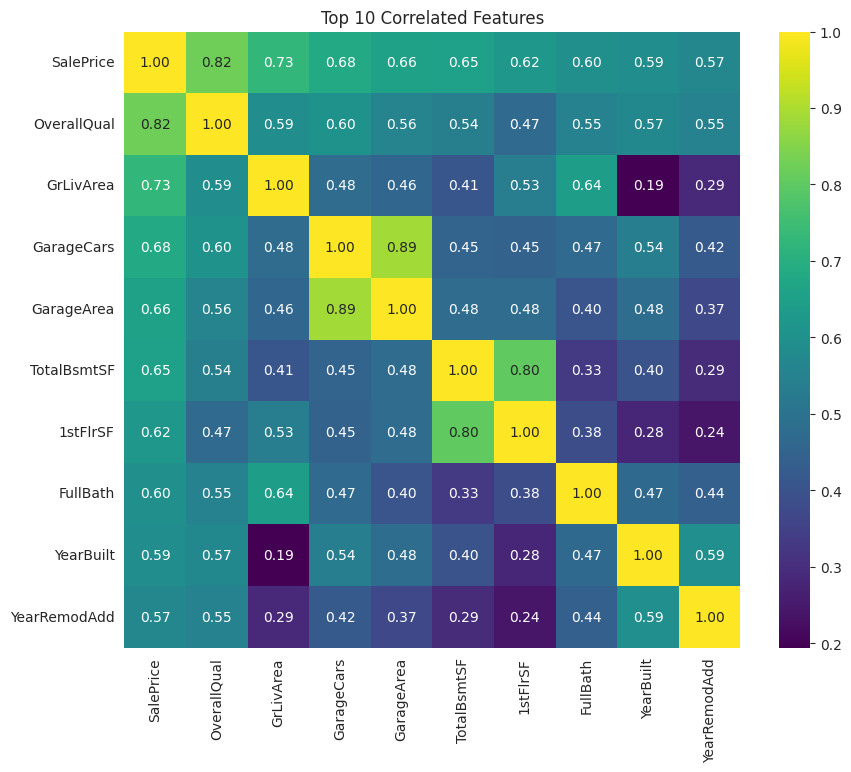


Data concatenated. Train rows: 1458, Test rows: 1459, Total: (2917, 79)


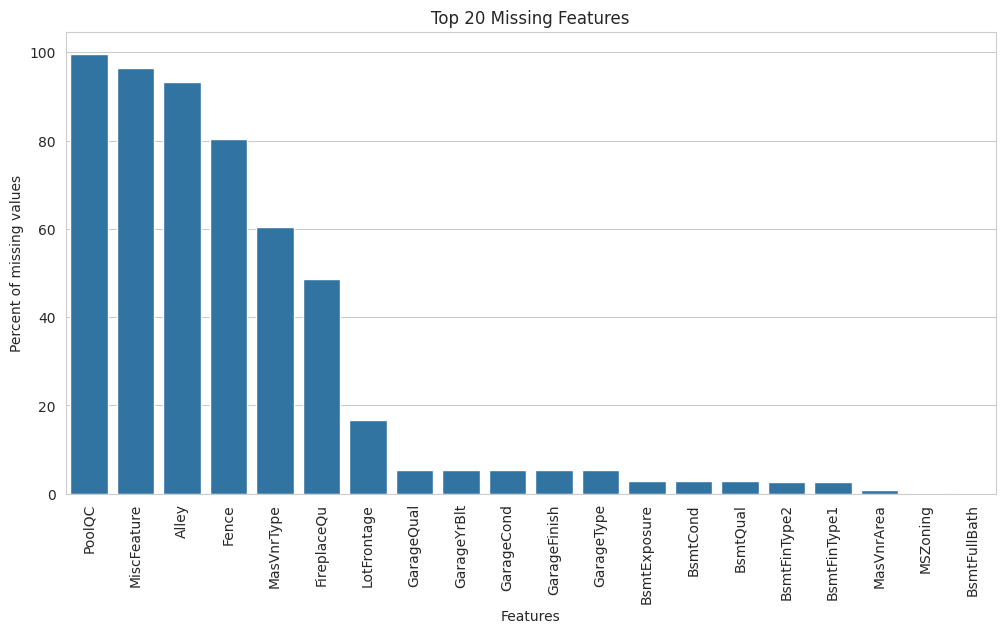

In [9]:
# 2. EDA (EXPLORATORY DATA ANALYSIS)

# --- 2.1 ANALYSIS OF OUTLIERS ---
# Visualizing the relationship between living space and price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'], alpha=0.6)
plt.title('Living Area vs Sale Price (Before Outlier Removal)')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
# Draw lines to show the emission zone
plt.axvline(x=4000, color='r', linestyle='--')
plt.axhline(y=300000, color='r', linestyle='--')
plt.text(4100, 200000, 'Anomalies', color='red', fontsize=12)
plt.show()

# Remove obvious outliers: huge area (>4000), but low price (<300000)
# This is critical, as they greatly distort linear models (Lasso, Ridge)
outliers = train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index
train = train.drop(outliers)
print(f"Removed {len(outliers)} outliers.")


# --- 2.2 ANALYSIS OF THE TARGET VARIABLE ---

def plot_distribution(data, title):
    """
    The function builds a histogram with a normal distribution overlay
    and a QQ plot to check the normality of the data.
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    # 1. Histogram + KDE
    # stat="density" normalizes the graph so that a normal distribution can be superimposed
    sns.histplot(data, kde=True, stat="density", ax=ax[0], color='blue', alpha=0.4)

    # Apply the normal distribution curve
    (mu, sigma) = norm.fit(data)
    xmin, xmax = ax[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)
    ax[0].plot(x, p, 'k', linewidth=2, label=f'Normal dist. ($\mu=${mu:.2f}, $\sigma=${sigma:.2f})')
    ax[0].legend()
    ax[0].set_title(f'{title} Distribution')

    # 2. QQ-Plot
    stats.probplot(data, plot=ax[1])
    ax[1].set_title(f'{title} QQ-Plot')

    plt.show()

# Building graphs BEFORE transformation
print("\n--- Analysis before logarithmization ---")
plot_distribution(train['SalePrice'], 'Original SalePrice')

# Apply Log-Transformation for normalization (log(1+x))
# This corrects skewness
train["SalePrice"] = np.log1p(train["SalePrice"])

# Building graphs AFTER transformation
print("\n--- Analysis after logarithmization ---")
plot_distribution(train['SalePrice'], 'Log(SalePrice)')


# --- 2.3 CORRELATION ANALYSIS ---
# Let's see which factors have the strongest influence on price
numeric_train = train.select_dtypes(include=[np.number])
k = 10  #Top 10 features
cols = numeric_train.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
            yticklabels=cols.values, xticklabels=cols.values, cmap='viridis')
plt.title('Top 10 Correlated Features')
plt.show()


# --- 2.4 DATA COMBINATION ---
# Important: save sample sizes AFTER removing outliers
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

# Combining train and test for consistent feature engineering
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print(f"\nData concatenated. Train rows: {ntrain}, Test rows: {ntest}, Total: {all_data.shape}")


# --- 2.5 ANALYSIS OF GAPS ---
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)

if len(all_data_na) > 0:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=all_data_na.index[:20], y=all_data_na[:20])
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Percent of missing values')
    plt.title('Top 20 Missing Features')
    plt.show()
else:
    print("No gaps found.")

In [10]:
# 3. FEATURE ENGINEERING

print("\n--- Start Feature Engineering ---")

# --- 3.1 IMPUTATION ---
# We use domain knowledge to fill in

# Group 1: NA means “None”
# For example, if there is no garage, then GarageType = NA. This is not a missing value, it is the category “NoGarage”.
cols_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType']
for col in cols_none:
    all_data[col] = all_data[col].fillna('None')

# Group 2: NA means 0 (Numerical)
# If there is no garage, then its area = 0.
cols_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
             'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
for col in cols_zero:
    all_data[col] = all_data[col].fillna(0)

# Group 3: LotFrontage (Frontage length)
# Fill in with the median for the neighborhood, since houses in the same neighborhood are similar.
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# Group 4: Categorical features (fill in with the mode—the most frequent value)
# There are very few omissions here, so the mode is a safe option.
cols_mode = ['MSZoning', 'Utilities', 'Functional', 'Exterior1st', 'Exterior2nd',
             'SaleType', 'KitchenQual', 'Electrical']
for col in cols_mode:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Check for remaining gaps
total_missing = all_data.isnull().sum().sum()
print(f"Total missing values left: {total_missing}")


# --- 3.2 CREATING NEW FEATURES (FEATURE CREATION) ---

# 1. Type conversion
# Some numbers are actually categories.
# For example, MSSubClass (housing type) is a code, not a value.
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# 2. Creating aggregated features (Strongest features)
# Total house area (basement + 1st floor + 2nd floor)
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Total number of bathrooms
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                        all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

# 3. Binary attributes (Yes/No)
for col in ['PoolArea', '2ndFlrSF', 'GarageArea', 'TotalBsmtSF', 'Fireplaces']:
    all_data['Has' + col] = all_data[col].apply(lambda x: 1 if x > 0 else 0)

print("New features created: TotalSF, TotalBath, HasPool, etc.")


# --- 3.3 CORRECTING SKEWNESS ---
# Numerical features with strong skewness should be logarithmized, as should the target variable.
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Calculate the asymmetry coefficient
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = skewed_feats[abs(skewed_feats) > 0.75] # Порог 0.75
print(f"Skewed numerical features detected: {len(skewness)}")

# We apply the Box-Cox transformation (log1p works perfectly and safely)
skewed_features = skewness.index
all_data[skewed_features] = np.log1p(all_data[skewed_features])


# --- 3.4 ENCODING ---
# Converting categories into numbers (One-Hot Encoding)
all_data = pd.get_dummies(all_data)
print(f"Shape after dummy encoding: {all_data.shape}")

# --- 3.5 DIVIDING BACK INTO TRAIN AND TEST ---
# We use the saved ntrain to clearly divide the data
train = all_data[:ntrain]
test = all_data[ntrain:]

print(f"Final Train shape: {train.shape}")
print(f"Final Test shape: {test.shape}")


# 4. MODELING (STACKING ENSEMBLE)

print("\n--- Start Modeling ---")

# --- 4.1 VALIDATION CONFIGURATION ---
n_folds = 5

def rmsle_cv(model):
    """
    Function for cross-validation.
    Returns RMSE (since the target variable is already logarithmic, this is equal to RMSLE).
    """
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return(rmse)

# --- 4.2 DEFINING BASIC MODELS ---
# We use RobustScaler in all linear models for robustness to outliers.

# 1. LASSO (L1 regularization)
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

# 2. Elastic Net (L1 + L2)
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

# 3. Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#4. Gradient Boosting (Huber loss makes it robust to outliers)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

# 5. XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, verbosity=0, # removed silent=1 (deprecated)
                             random_state =7, n_jobs=-1)

# 6. LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,
                              verbose=-1)

 # --- 4.3 CHECKING BASIC MODELS
print("Evaluating base models (this might take a minute)...")
score = rmsle_cv(lasso)
print(f"Lasso score: {score.mean():.4f} ({score.std():.4f})")
score = rmsle_cv(model_xgb)
print(f"XGBoost score: {score.mean():.4f} ({score.std():.4f})")


# --- 4.4 STACKING CLASS (the heart of the project) ---
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Conversion to numpy array for safety
        if isinstance(X, pd.DataFrame): X = X.values

        # Matrix for storing out-of-fold predictions
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))

        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Training the meta-model on predictions from base models
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    def predict(self, X):
        if isinstance(X, pd.DataFrame): X = X.values
        # Averaging predictions from base models
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        # We put them into a meta model
        return self.meta_model_.predict(meta_features)

# Initialization of stacking
# Base models: ENet, GBoost, KRR (they are different in nature, which is good for the ensemble)
# Meta-model: Lasso (a simple linear model to combine the results)
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

print("Stacking model initialized.")


--- Start Feature Engineering ---
Total missing values left: 0
New features created: TotalSF, TotalBath, HasPool, etc.
Skewed numerical features detected: 24
Shape after dummy encoding: (2917, 338)
Final Train shape: (1458, 338)
Final Test shape: (1459, 338)

--- Start Modeling ---
Evaluating base models (this might take a minute)...
Lasso score: 0.1095 (0.0070)
XGBoost score: 0.1162 (0.0060)
Stacking model initialized.



--- Final Training & Evaluation ---
Training Stacked Model...
Stacked RMSLE on train: 0.0777
Training XGBoost...
XGBoost RMSLE on train: 0.0857
Training LightGBM...
LightGBM RMSLE on train: 0.0721

Blending models...


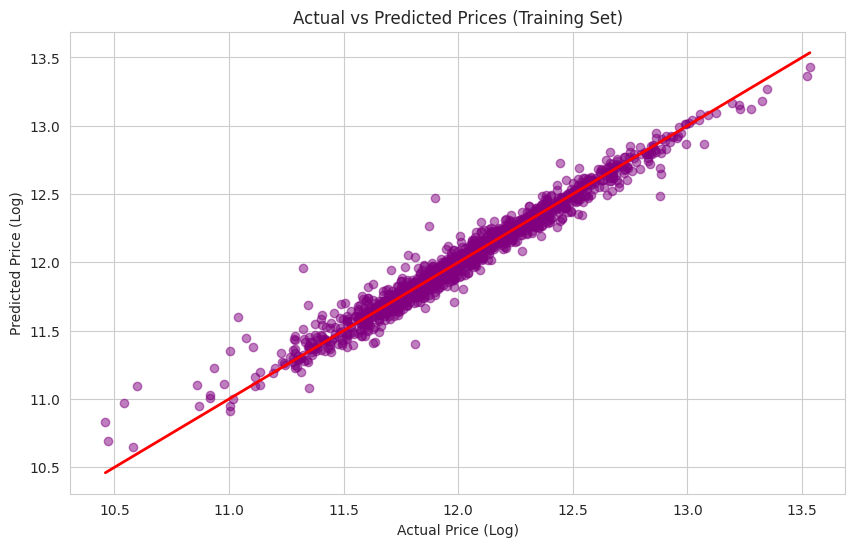

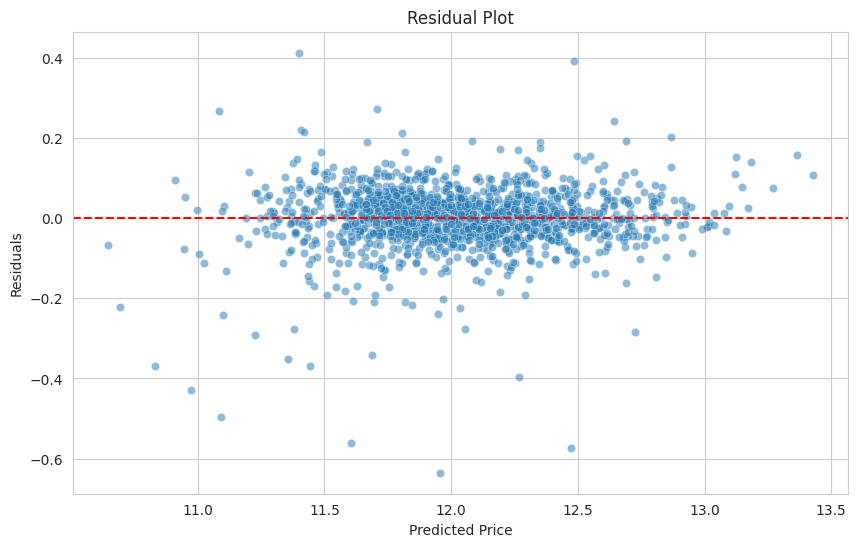


--- Model Interpretation (SHAP) ---


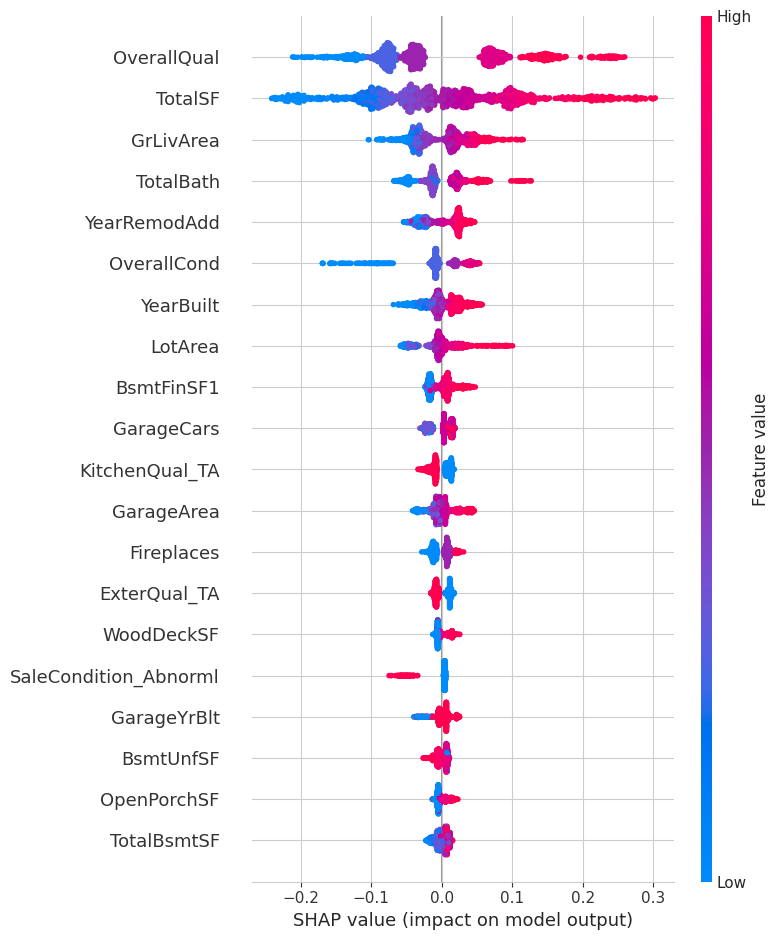


Done! Submission saved to 'submission_kaggle_final.csv'


In [11]:
# 5. TRAINING & EVALUATION

print("\n--- Final Training & Evaluation ---")

# Evaluation function (RMSLE)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

#1. Training the Stacking Model (the most powerful)
print("Training Stacked Model...")
stacked_averaged_models.fit(train.values, y_train)
# Predict on the trainer (for verification) and on the test (for submission)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values)) # Return from logarithm
print(f"Stacked RMSLE on train: {rmsle(y_train, stacked_train_pred):.4f}")

# 2. Training XGBoost
print("Training XGBoost...")
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(f"XGBoost RMSLE on train: {rmsle(y_train, xgb_train_pred):.4f}")

# 3. Training LightGBM
print("Training LightGBM...")
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test))
print(f"LightGBM RMSLE on train: {rmsle(y_train, lgb_train_pred):.4f}")


# --- 5.1 BLENDING ---
# We blend the predictions. Stacking gets the most weight because it learned from mistakes.
# XGB and LGB add diversity and stability.
print("\nBlending models...")
ensemble = stacked_pred * 0.70 + xgb_pred * 0.15 + lgb_pred * 0.15


# --- 5.2 ERROR ANALYSIS ---
ensemble_train = stacked_train_pred * 0.70 + xgb_train_pred * 0.15 + lgb_train_pred * 0.15

# Graph 1: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_train, ensemble_train, alpha=0.5, color='purple')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2)
plt.xlabel('Actual Price (Log)')
plt.ylabel('Predicted Price (Log)')
plt.title('Actual vs Predicted Prices (Training Set)')
plt.show()

# Graph 2: Residuals
# Ideally, the points should be scattered randomly around 0.
# If there is a pattern (e.g., a “smile”), it means that the model has missed some nonlinearity.
residuals = y_train - ensemble_train
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ensemble_train, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


# 6. INTERPRETATION (SHAP)

print("\n--- Model Interpretation (SHAP) ---")
# We use XGBoost for interpretation (it is fast and easy to understand)
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(train)

# Building a graph of feature importance
plt.figure()
shap.summary_plot(shap_values, train, max_display=20)
plt.show()

# 7. SUBMISSION

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission_final_super.csv', index=False)

print("\nDone! Submission saved to 'submission_kaggle_final.csv'")